In [8]:
import numpy as np
import torch 
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset 
import copy
from sklearn.model_selection import train_test_split

In [9]:
import torchvision 

import matplotlib.pyplot as plt 
from IPython import display 
display.set_matplotlib_formats('svg')

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15668\945609067.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [10]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
cdata=torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)

100.0%


Extracting emnist\EMNIST\raw\gzip.zip to emnist\EMNIST\raw


In [12]:
print(cdata.classes)
print(str(len(cdata.classes))+'classes')

print('\nData size:')
print(cdata.data.shape)

images=cdata.data.view([124800,1,28,28]).float()
print('\nTensor data:')
print(images.shape)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27classes

Data size:
torch.Size([124800, 28, 28])

Tensor data:
torch.Size([124800, 1, 28, 28])


In [13]:
print(torch.sum(cdata.targets==0))

torch.unique(cdata.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [14]:
cdata.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [16]:
letterCategories =cdata.classes[1:]

labels=copy.deepcopy(cdata.targets)-1
print(labels.shape)

print(torch.sum(labels==0))
torch.unique(labels)

torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

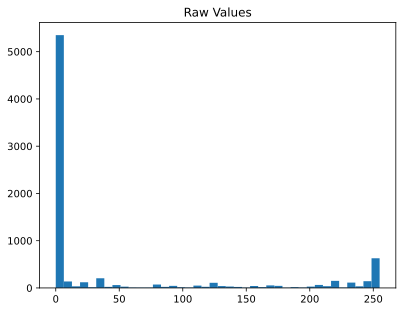

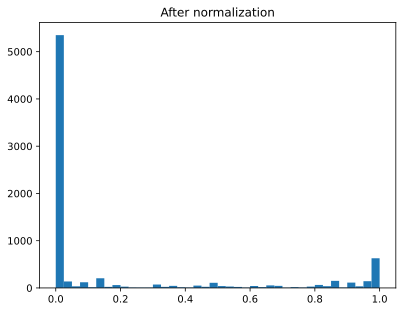

In [18]:
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title('Raw Values')
plt.show()

images /=torch.max(images)

plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title('After normalization')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

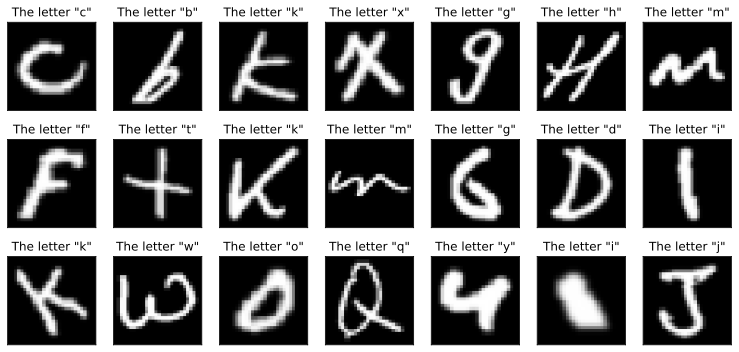

In [20]:
fig,axs=plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
    whichpic=np.random.randint(images.shape[0])
    I=np.squeeze(images[whichpic,:,:])
    letter=letterCategories[labels[whichpic]]
    ax.imshow(I.T,cmap='gray')
    ax.set_title('The letter "%s"'%letter)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show

In [21]:
train_data,test_data,train_labels,test_labels=train_test_split(images,labels,test_size=.1)

train_data=TensorDataset(train_data,train_labels)
test_data=TensorDataset(test_data,test_labels)

batchsize=32
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [22]:
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


In [33]:
def makeTheNet(printtoggle=False):
    
    class emnistnet(nn.Module):
        
        def _init_(self,printtoggle):
            super()._init_()
            self.print=printtoggle
            self.conv1=nn.Conv2d(1,6,3,padding=1)
            self.bnorm1=nn.BatcchNorm2d(6)
            self.conv2=nn.Conv2d(6,6,3,padding=1)
            self.bnorm2=nn.BatcchNorm2d(6)
            self.fc1=nn.Linear(7*7*6,50)
            self.fc2=nn.Linear(50,26)

        def forward(self,x):
            if self.print:print(f'Input:{list(x.shape)}')
            x=F.max_pool2d(self.conv1(x),2)
            x=F.leaky_relu(self.bnorm1(x))
            
            if self.print:print(f'First CPR block:{list(x.shape)}')
            x=F.max_pool2d(self.conv2(x),2)
            x=F.leaky_relu(self.bnorm2(x))
            
            if self.print:print(f'Second CPR block:{list(x.shape)}')
            nUnits=x.shape.num1()/x.shape[0]
            x=x.view(-1,int(nUnits))
            
            if self.print:print(f'Vectorized:{list(x.shape)}')
            x=F.leaky_relu(self.fc1(x))
            x=self.fc2(x)
            
            if self.print:print(f'Final output:{list(x.shape)}')
            return x
            
    net=emnistnet(printtoggle)
    lossfun=nn.CrossEntropyLoss()
    optimizer=torch.optim.Admin(net.parameters(),lr=.001)
    return net,lossfun,optimizer

In [34]:
net,lossfun,optimizer = makeTheNet(True)

X,y=iter(train_loader).next()
yHat= net(X)

print('\Output size:')
print(yHat.shape)

loss=lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

TypeError: emnistnet.__init__() takes 1 positional argument but 2 were given